## **Objective**

- The competition is **obviously intended to do multi-class segmentatio**n (it is not multilabel segmentation as I read in some discussions or notebooks). The **competition's host** has confirmed it here in a comment on this discussion that there is just one segmentation, which is either for the large bowel, small bowel, or stomach when a kaggler questioned him in **a comment**: "Why is **there overlap in the annotations?**", the host answers: "We **sometimes** overlap segmentations **inadvertently** in an effort to not miss any of these organs. **Could you please upload a picture of this case?**"  

The link to the discussion I mentioned above is: https://www.kaggle.com/competitions/uw-madison-gi-tract-image-segmentation/discussion/319385  

And I I'm referring to the comment made by Balaji Selvaraj as well as the answer of the competition host

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
pd.set_option('chained_assignment',None)
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import os
import cv2
from glob import glob
import gc

from sklearn.model_selection import StratifiedKFold, KFold, StratifiedGroupKFold
import pandas as pd
pd.options.mode.chained_assignment = None 

## **Prepare & Rearrange Data (as it was for MRI images)**

In [2]:
TRAIN_ROOT_DIR = '../input/uw-madison-gi-tract-image-segmentation/train'

In [3]:
train_df_original = pd.read_csv('../input/uw-madison-gi-tract-image-segmentation/train.csv')

print(train_df_original.shape)
train_df_original.head()

(115488, 3)


,id,class,segmentation
0,case123_day20_slice_0001,large_bowel,NaN
1,case123_day20_slice_0001,small_bowel,NaN
2,case123_day20_slice_0001,stomach,NaN
3,case123_day20_slice_0002,large_bowel,NaN
4,case123_day20_slice_0002,small_bowel,NaN


In [4]:
def prepare_df(df, root_dir):
    all_images = []
    for path in Path(root_dir).rglob('*.png'):

        parts = path.parts
        dict_path = {}
        case_str = parts[4][4:]
        day_str = parts[5].split('_')[1][3:]
        dict_path['case'] = int(case_str)
        dict_path['day'] = int(day_str)
        dict_path['slice'] = int(parts[7].split('_')[1])
        slice_str = '_'.join(parts[7].split('_')[0:2])
        #dict_path['PosixPath'] = path
        dict_path['path'] = str(path)
        dict_path['join_col'] = 'case'+ case_str + '_'+ 'day' + day_str + '_' + slice_str
        dict_path['height'] = int(dict_path['path'].split('/')[7].split('_')[2])
        dict_path['width'] = int(dict_path['path'].split('/')[7].split('_')[3])
        dict_path['subject'] = case_str + '_'+ day_str
        dict_path['matching_str_inference'] = dict_path['subject'] + '_' +str(dict_path['slice'])
        all_images.append(dict_path)
    
    
    df_1_3 = pd.DataFrame(all_images) 
    # Get the final dataframe with the same length of the original one...
    df_final = pd.merge(df, df_1_3, left_on = 'id', right_on = 'join_col')
    df_final = df_final.drop('join_col', axis=1)

    return df_final

In [5]:
def rearrange_df(df):
    """ 
    Rearrange data in the the prepared DataFrame (train_df or test_df).
    For each id (repeated 3 times),it creates 3 associated columns representing the segmentation 
    for the 3 classes:'large_bowel', 'small_bowel', 'stomach' 
    """
    # I just keep one ID as a result (so that it is not repeated three times).
    df_rearranged = pd.DataFrame({"id": df["id"][::3]}) 
    df_rearranged["large_bowel"] = df["segmentation"][::3].values
    df_rearranged["small_bowel"] = df["segmentation"][1::3].values
    df_rearranged["stomach"] = df["segmentation"][2::3].values

    # Adjust the corresponding other columns
    df_rearranged["case"] = df["case"][::3].values
    df_rearranged["day"] = df["day"][::3].values
    df_rearranged["subject"] = df["subject"][::3].values
    df_rearranged["slice"] = df["slice"][::3].values
    df_rearranged["path"] = df["path"][::3].values
    df_rearranged["width"] = df["width"][::3].values
    df_rearranged["height"] = df["height"][::3].values
    df_rearranged["matching_str_inference"] = df["matching_str_inference"][::3].values
    
    df_rearranged = df_rearranged.reset_index(drop=True)
    df_rearranged = df_rearranged.fillna("")
    # I keep track of the classes for which segmentation exists (I mean rle encoding),
    # I'll use it for the validation strategy
    # 0: No segmentation
    # 1: Only one class has segmentation
    # 2: Only two classes have segmentation
    # 3: For the three classes, we have segmentation.
    df_rearranged["count"] = np.sum(df_rearranged.iloc[:, 1:4] != "", axis=1).values
    
    
    # The number of slices is important, but it's not the sole factor in my first validation.
    # but also the segmentation type coexisting in the same slice.
    # For example an image with 2 segmentations: large_bowel & small_bowel is different from
    # an image that has also 2 segmentation but large_bowel & stomach
    # I tried to add a new column to include this idea (for my validation strategy)
    # background : 0 means no segmentation/ bk_large_bowel':1, means we have just one large_bowel
    # segmentation etc. => we have 8 possible cases (type of slices)
    type_slices = {'background':0, 'bk_large_bowel':1,'bk_small_bowel':2,'bk_stomach':3,
                             'bk_smallbowel_stomach':4,'bk_largebowel_stomach':5,
                             'bk_large_small_bowel':6,'bk_small_large_bowel_stomach':7}
 
    df_rearranged["slice_type"] = df_rearranged.apply(lambda x: type_slices['bk_small_large_bowel_stomach'] if x['count']==3 else (type_slices['bk_large_small_bowel'] if (x['count']==2)&(x['large_bowel']!="")&(x['small_bowel']!="") else (type_slices['bk_largebowel_stomach'] if (x['count']==2)&(x['large_bowel']!="")&(x['stomach']!="") else (type_slices['bk_smallbowel_stomach'] if (x['count']==2)&(x['small_bowel']!="")&(x['stomach']!="") else (type_slices['bk_large_bowel'] if (x['count']==1)&(x['large_bowel']!="") else(type_slices['bk_small_bowel'] if (x['count']==1)&(x['small_bowel']!="") else (type_slices['bk_stomach'] if (x['count']==1)&(x['stomach']!="") else type_slices['background'])))))),axis=1)
                                                      
    return df_rearranged

In [6]:
train_df = prepare_df(train_df_original, TRAIN_ROOT_DIR)
train_df_rearranged = rearrange_df(train_df)


In [7]:
# According to this discussion : 
# https://www.kaggle.com/competitions/uw-madison-gi-tract-image-segmentation/discussion/319963#1763869
# I'll remove misslabeled training data

train_df_rearranged = train_df_rearranged[(train_df_rearranged['case']!=7)|(train_df_rearranged['day']!=0)]
train_df_rearranged = train_df_rearranged.reset_index(drop=True)

train_df_rearranged = train_df_rearranged[(train_df_rearranged['case']!=81)|(train_df_rearranged['day']!=30)]
train_df_rearranged = train_df_rearranged.reset_index(drop=True)

## **Validation Strategy (first idea)¶**

- A slice for a given case shouldn't be present in both the train and validation sets at the same time.
- So: either the train set or the validation set should contain the entire case ==> GroupFold (on'case' column)
- Based on the type of slice, "slice type" which I added in the rearrange_df function, stratified folds are created ==> StratifiedGroupKFold


In [8]:
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (_, val_idx) in enumerate(sgkf.split(X=train_df_rearranged,y=train_df_rearranged["slice_type"],
        groups=train_df_rearranged["case"]),1): # the 1st fold has index 1 not 0
    train_df_rearranged.loc[val_idx, "fold"] = fold

train_df_rearranged["fold"] = train_df_rearranged["fold"].astype(np.uint8)

In [9]:
# fold = 1
fold_selected = 1
train_ids = train_df_rearranged[train_df_rearranged["fold"] != fold_selected].index
valid_ids = train_df_rearranged[train_df_rearranged["fold"] == fold_selected].index

X_train = train_df_rearranged[train_df_rearranged.index.isin(train_ids)]
X_valid = train_df_rearranged[train_df_rearranged.index.isin(valid_ids)]


## **Huge overlapping pixels: investigation**

In [10]:
def rle2mask(mask_rle, shape, color=1):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, color - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = color
    return img.reshape(shape) 

In [11]:
# This function was created to show all the cases where we have overlapping pixels.
# in the next paragraph, It will be modified to deal with these overlapping pixels.

def create_2d_masks_verif_overlapping_poxels(df):
    # class 'large_bowel' : 1 
    df.loc[:,'large_bowel'] = df.apply(lambda x: cv2.resize(rle2mask(x['large_bowel'],
                    shape = (x['width'],x['height']), color=1),(128,128)).astype(np.uint8),axis=1)
    # class 'small_bowel' : 2
    df.loc[:,'small_bowel'] = df.apply(lambda x: cv2.resize(rle2mask(x['small_bowel'],
                    shape = (x['width'],x['height']), color=2),(128,128)).astype(np.uint8),axis=1)
    # class 'stomack' : 3
    df.loc[:,'stomach'] = df.apply(lambda x: cv2.resize(rle2mask(x['stomach'],
                    shape = (x['width'],x['height']), color=3),(128,128)).astype(np.uint8),axis=1)

    # Then, I will sum all segmentation in one mask to detect the overlapping pixels
    df['mask'] = df['large_bowel'] + df['small_bowel'] + df['stomach']
    
    # I'll use the following column to detect, in the case of count = 3 (when we have 3 segmentations),
    # the overlapping pixels of large_bowel & small_bowel (1+2=3), 
    # Due to the fact that having these cases (together with the concurrent class stomach (=3)) will be confusing..
  
    df['mask_small_large'] = df['large_bowel'] + df['small_bowel'] 

    return df

In [12]:
masks_fold1= create_2d_masks_verif_overlapping_poxels(X_train)

In [13]:
# Recall (I explained this in the df_rearrange fnction above)
type_slices = {'background':0, 'bk_large_bowel':1,'bk_small_bowel':2,'bk_stomach':3,
                             'bk_smallbowel_stomach':4,'bk_largebowel_stomach':5,
                             'bk_large_small_bowel':6,'bk_small_large_bowel_stomach':7}

#### **Case1: overlapping pixels : large_bowel + small_bowel (1+2=3)** 
- See the Result: 
In **16%** of the slices having the segmentations "large bowel" and "small bowel," there are **overlapping pixels**.
(type_slices['bk_large_small_bowel']=6)

In [14]:
small_large= masks_fold1[masks_fold1['slice_type']==6]
print(len(small_large))
small_large.head(2)


6402


,id,large_bowel,small_bowel,stomach,case,day,subject,slice,path,width,height,matching_str_inference,count,slice_type,fold,mask,mask_small_large
938,case133_day0_slice_0075,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",133,0,133_0,75,../input/uw-madison-gi-tract-image-segmentatio...,310,360,133_0_75,2,6,5,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
939,case133_day0_slice_0076,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",133,0,133_0,76,../input/uw-madison-gi-tract-image-segmentatio...,310,360,133_0_76,2,6,5,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [15]:
# 16% of these slices have overlapping pixels!(1053 over 6402)
masks_small_large = list(small_large['mask'].values)
overlapping_masks_indices = [i for i, mask in enumerate(masks_small_large) if 3 in mask]
print(len(overlapping_masks_indices)) 
print(overlapping_masks_indices)
# And this case is really misleading, since 3 (the sum of overalpping pixels is the calss stomach!)


1053
[13, 21, 30, 31, 34, 70, 71, 73, 93, 95, 100, 101, 102, 106, 111, 115, 116, 117, 121, 140, 166, 171, 180, 181, 204, 208, 212, 234, 243, 244, 245, 255, 273, 274, 282, 288, 289, 297, 300, 310, 311, 313, 314, 316, 317, 320, 402, 403, 410, 432, 435, 436, 438, 452, 474, 475, 546, 547, 548, 549, 561, 569, 570, 571, 593, 596, 598, 605, 606, 634, 635, 640, 667, 669, 675, 676, 677, 678, 738, 747, 756, 771, 773, 784, 787, 788, 791, 799, 801, 802, 803, 814, 815, 817, 828, 829, 831, 832, 833, 834, 839, 840, 865, 866, 867, 868, 869, 870, 871, 878, 879, 880, 881, 882, 883, 884, 891, 898, 900, 901, 902, 903, 904, 905, 906, 907, 908, 909, 910, 911, 912, 914, 915, 916, 917, 918, 919, 922, 935, 936, 937, 938, 939, 940, 941, 942, 943, 944, 945, 946, 947, 949, 950, 951, 952, 953, 956, 962, 1033, 1034, 1056, 1059, 1071, 1074, 1097, 1098, 1099, 1100, 1101, 1103, 1104, 1105, 1106, 1107, 1108, 1109, 1110, 1141, 1142, 1143, 1144, 1146, 1147, 1152, 1165, 1166, 1178, 1191, 1194, 1204, 1218, 1219, 1221, 1231

#### **Case2: overlapping pixels : large_bowel + stomach : 1+3 = 4** 

(type_slices['bk_largebowel_stomach']=5)

In [16]:
stomach_large= masks_fold1[masks_fold1['slice_type']==5]
print(len(stomach_large))
stomach_large.head(2)

2440


,id,large_bowel,small_bowel,stomach,case,day,subject,slice,path,width,height,matching_str_inference,count,slice_type,fold,mask,mask_small_large
912,case133_day0_slice_0049,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",133,0,133_0,49,../input/uw-madison-gi-tract-image-segmentatio...,310,360,133_0_49,2,5,5,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
913,case133_day0_slice_0050,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",133,0,133_0,50,../input/uw-madison-gi-tract-image-segmentatio...,310,360,133_0_50,2,5,5,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [17]:
# 65 over 2440 of these slices have overlapping pixels
masks_stomach_large = list(stomach_large['mask'].values)
overlapping_masks_indices = [i for i, mask in enumerate(masks_stomach_large) if 4 in mask]
print(len(overlapping_masks_indices)) 
print(overlapping_masks_indices) 

65
[148, 149, 307, 460, 535, 536, 553, 570, 574, 577, 578, 579, 580, 581, 585, 586, 587, 593, 594, 595, 596, 766, 775, 779, 820, 821, 833, 834, 835, 836, 837, 838, 839, 915, 1034, 1162, 1523, 1527, 1528, 1583, 1585, 1795, 1796, 1797, 1884, 1885, 1906, 1914, 1915, 1916, 2199, 2206, 2207, 2218, 2224, 2226, 2227, 2228, 2412, 2413, 2414, 2415, 2417, 2418, 2421]


#### **Case3: overlapping pixels : small_bowel + stomach : 2+3 = 5** 

(type_slices['bk_smallbowel_stomach']=4)

In [18]:
stomach_small= masks_fold1[masks_fold1['slice_type']==4]
print(len(stomach_small))
stomach_small.head(2)

125


,id,large_bowel,small_bowel,stomach,case,day,subject,slice,path,width,height,matching_str_inference,count,slice_type,fold,mask,mask_small_large
2066,case139_day18_slice_0051,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",139,18,139_18,51,../input/uw-madison-gi-tract-image-segmentatio...,266,266,139_18_51,2,4,5,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2067,case139_day18_slice_0052,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",139,18,139_18,52,../input/uw-madison-gi-tract-image-segmentatio...,266,266,139_18_52,2,4,5,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [19]:
# 15 over 125 of these slices have overlapping pixels
masks_stomach_small = list(stomach_small['mask'].values)
overlapping_masks_indices = [i for i, mask in enumerate(masks_stomach_small) if 5 in mask]
print(len(overlapping_masks_indices)) 
print(overlapping_masks_indices)

15
[23, 24, 25, 28, 29, 30, 31, 37, 38, 61, 76, 99, 102, 108, 122]


#### **Case4: overlapping pixels (when count=3) :**  

**(type_slices['bk_small_large_bowel_stomach']= 7)**
- 3 classes overlap: large_bowel+small_bowel+stomach(1+2+3=6)=> Later, I'll assign overlapping pixels to 3(stomach) ==> **See Result : 0% of slices have overlapping pixel**
- 2 classes overlap : large_bowel + stomach (1+3=4) : Later I'll assign overlapping pixels to 3 (stomach)  ==> **See Result 20% of slices have overlapping pixels (511 over 2561)**
- 2 classes overlap : small_bowel + stomach (2+3=5): Later, I'll assign overlapping pixels to 3 (stomach) ==> **See Result 15% of slices have overlapping pixels (385 over 2561)**

- But when 2 classes overlap (in this 4th case): large_bowel + small_bowel (1+2=3), I'll use the column 'mask_small_large', to detect them. later, I'll assign them to class 1 (large_bowel). In the modified function, this case will be treated, at the beginning, before creating 'mask' column. ==> **See Result 8% of slices have overlapping pixels (207 over 2561)**

In [20]:
stomach_large_small= masks_fold1[masks_fold1['slice_type']==7]
print(len(stomach_large_small))
stomach_large_small.head(2)

2561


,id,large_bowel,small_bowel,stomach,case,day,subject,slice,path,width,height,matching_str_inference,count,slice_type,fold,mask,mask_small_large
930,case133_day0_slice_0067,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",133,0,133_0,67,../input/uw-madison-gi-tract-image-segmentatio...,310,360,133_0_67,3,7,5,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
931,case133_day0_slice_0068,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",133,0,133_0,68,../input/uw-madison-gi-tract-image-segmentatio...,310,360,133_0_68,3,7,5,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [21]:
masks_stomach_small_large = list(stomach_large_small['mask'].values)

# The 3 classes overalp: 0% of slices having overlapping pixels
overlapping_masks_indices1 = [i for i, mask in enumerate(masks_stomach_small_large) if 6 in mask]
print(len(overlapping_masks_indices1)) 
print(overlapping_masks_indices1)

0
[]


In [22]:
# 2 classes overalp (large_bowel + stomach): 20% of slices have overlapping pixels!
overlapping_masks_indices2 = [i for i, mask in enumerate(masks_stomach_small_large) if 4 in mask]
print(len(overlapping_masks_indices2))  
print(overlapping_masks_indices2)

511
[6, 14, 20, 50, 51, 56, 57, 58, 79, 84, 91, 106, 148, 150, 171, 172, 173, 174, 175, 198, 199, 201, 210, 212, 221, 269, 274, 280, 282, 284, 285, 286, 287, 288, 289, 290, 310, 311, 313, 321, 335, 345, 346, 348, 373, 377, 379, 384, 388, 401, 402, 403, 407, 408, 409, 410, 411, 412, 413, 414, 416, 465, 479, 480, 481, 484, 485, 486, 487, 488, 489, 490, 491, 495, 498, 505, 506, 540, 541, 545, 553, 554, 615, 616, 617, 627, 628, 630, 640, 641, 648, 649, 650, 651, 652, 653, 654, 671, 678, 680, 681, 682, 688, 689, 690, 691, 692, 703, 704, 705, 710, 711, 720, 721, 722, 723, 724, 731, 784, 785, 786, 787, 803, 804, 805, 806, 812, 813, 818, 819, 820, 823, 824, 825, 826, 827, 834, 903, 904, 907, 910, 911, 912, 913, 914, 919, 923, 924, 925, 926, 927, 928, 929, 931, 937, 941, 945, 946, 947, 948, 949, 950, 951, 952, 953, 954, 955, 956, 957, 958, 959, 965, 966, 967, 973, 974, 975, 976, 977, 978, 983, 984, 985, 986, 987, 988, 989, 998, 999, 1000, 1001, 1002, 1011, 1013, 1014, 1016, 1018, 1026, 1027, 10

In [23]:
# 2 classes overalp (small_bowel + stomach): 15% of slices having overlapping pixels!
overlapping_masks_indices3 = [i for i, mask in enumerate(masks_stomach_small_large) if 5 in mask]
print(len(overlapping_masks_indices3))  
print(overlapping_masks_indices3)

385
[5, 6, 9, 12, 20, 40, 50, 56, 58, 79, 84, 91, 133, 135, 150, 171, 172, 173, 198, 199, 201, 211, 212, 213, 268, 271, 311, 377, 378, 380, 402, 407, 410, 411, 412, 417, 418, 453, 465, 484, 485, 486, 487, 488, 489, 490, 491, 495, 540, 541, 604, 606, 607, 608, 614, 615, 616, 617, 618, 619, 620, 621, 627, 628, 629, 630, 640, 641, 642, 643, 644, 649, 650, 672, 690, 692, 693, 703, 704, 705, 706, 707, 720, 721, 722, 723, 724, 731, 784, 785, 786, 787, 803, 804, 806, 818, 820, 822, 825, 834, 841, 884, 902, 903, 905, 906, 907, 910, 913, 914, 921, 923, 924, 937, 942, 943, 946, 947, 950, 951, 952, 953, 954, 955, 956, 957, 958, 959, 966, 975, 978, 983, 984, 985, 986, 987, 988, 999, 1000, 1002, 1011, 1012, 1013, 1027, 1030, 1031, 1032, 1034, 1037, 1043, 1044, 1045, 1046, 1047, 1048, 1057, 1071, 1082, 1083, 1085, 1086, 1095, 1096, 1097, 1098, 1099, 1106, 1126, 1127, 1129, 1142, 1143, 1144, 1145, 1146, 1147, 1218, 1219, 1220, 1223, 1228, 1229, 1231, 1308, 1309, 1324, 1325, 1347, 1348, 1349, 1350, 13

In [24]:
# 2 classes overlap (in the case when count=3): small_bowel +large_bowel (1+2=3)
# it is critical to detect these cases, since they have the same value as the stomach :3
# 8% of these slices have overlapping pixels
masks_stomach_small_large = list(stomach_large_small['mask_small_large'].values)


overlapping_masks_indices4 = [i for i, mask in enumerate(masks_stomach_small_large) if 3 in mask]
print(len(overlapping_masks_indices4)) 
print(overlapping_masks_indices4)

207
[51, 53, 79, 89, 91, 120, 121, 144, 167, 169, 181, 182, 183, 184, 217, 235, 285, 288, 289, 290, 300, 301, 324, 325, 326, 328, 329, 330, 343, 363, 381, 382, 383, 384, 423, 424, 425, 430, 431, 432, 442, 443, 444, 497, 498, 499, 500, 612, 613, 674, 675, 676, 677, 683, 691, 692, 693, 694, 695, 696, 697, 698, 699, 700, 701, 702, 714, 789, 791, 804, 810, 933, 934, 960, 961, 1019, 1020, 1021, 1057, 1109, 1110, 1111, 1112, 1113, 1218, 1219, 1220, 1225, 1233, 1247, 1281, 1283, 1287, 1288, 1392, 1393, 1406, 1407, 1416, 1418, 1419, 1420, 1421, 1422, 1437, 1455, 1457, 1508, 1515, 1552, 1557, 1558, 1560, 1561, 1562, 1563, 1633, 1634, 1635, 1636, 1637, 1638, 1645, 1646, 1647, 1648, 1649, 1650, 1651, 1657, 1658, 1659, 1660, 1668, 1669, 1670, 1687, 1688, 1689, 1691, 1692, 1695, 1696, 1697, 1699, 1700, 1701, 1702, 1707, 1713, 1714, 1719, 1751, 1757, 1811, 1812, 1815, 1818, 1819, 1820, 1894, 1906, 1907, 1908, 1910, 1911, 1912, 1937, 1939, 1944, 1945, 1946, 1947, 1974, 1976, 1977, 1978, 1983, 1984, 1

## **Create a function to handle pixels that overlap** (inadvertently)

In [25]:
train_df = prepare_df(train_df_original, TRAIN_ROOT_DIR)
train_df_rearranged = rearrange_df(train_df)

In [26]:
train_df_rearranged = train_df_rearranged[(train_df_rearranged['case']!=7)|(train_df_rearranged['day']!=0)]
train_df_rearranged = train_df_rearranged.reset_index(drop=True)

train_df_rearranged = train_df_rearranged[(train_df_rearranged['case']!=81)|(train_df_rearranged['day']!=30)]
train_df_rearranged = train_df_rearranged.reset_index(drop=True)

In [27]:
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (_, val_idx) in enumerate(sgkf.split(X=train_df_rearranged,y=train_df_rearranged["slice_type"],
        groups=train_df_rearranged["case"]),1): # the 1st fold has index 1 not 0
    train_df_rearranged.loc[val_idx, "fold"] = fold

train_df_rearranged["fold"] = train_df_rearranged["fold"].astype(np.uint8)

In [28]:
# fold = 1
fold_selected = 1
train_ids = train_df_rearranged[train_df_rearranged["fold"] != fold_selected].index
valid_ids = train_df_rearranged[train_df_rearranged["fold"] == fold_selected].index

X_train = train_df_rearranged[train_df_rearranged.index.isin(train_ids)]
X_valid = train_df_rearranged[train_df_rearranged.index.isin(valid_ids)]

In [29]:
# Create a function that deals with overlapping pixels according to the slice type
#===========================
# When count=1 => when we have one segmentation: large_bowel or small_bowel or stomach, it is
# impossible to have overlapping pixels (since the RLE encoding was for one column, we can't have
# for example, two columns of "small_bowel")
#===========================
# When count=2 => We have 3 cases of possible overlapping pixels: 
# according to each case, I will assign the overlapping pixels to one class of the two

# large_bowel + small_bowel : 1+2 = 3 (type_slices['bk_large_small_bowel']=6) => assign to 1
#(and it will be misleading with 3, since 3 is the class of stomach!) 
# large_bowel + stomach : 1+3 = 4 (type_slices['bk_largebowel_stomach']=5) => assign to 3(stomach)
# small_bowel + stomach : 2+3 = 5 (type_slices['bk_smallbowel_stomach']=4) => assign to 3(stomach)
#==========================

# When count = 3, we have (04) possible cases of overlapping pixels.
# The three cases of count = 2 above (because we can have only two classes that may overlap)
# As well as the case where the three classes overlap (large_bowel+small_bowel+stomach = 6)
# type_slices['bk_small_large_bowel_stomach']=7 

# So when count=3 and When I have these 2 classes overlap(small_bowel + large_bowel) 
#==> they have a value of 3, which is the same value as the stomach that coexists with them. 
# ==> I'll treat them using the column'mask_small_large' at the beginning,before creating mask column.
# in all the other cases :  
# 3 classes overlap:large_bowel+small_bowel+stomach(1+2+3=6)=>assign overlapping pixels to3(stomach)
# 2 classes overap : large_bowel + stomach (1+3=4) assign overlapping pixels to 3 (stomach)
# 2 classes overlap : small_bowel + stomach (2+3=5) assign overlapping pixels to 3 (stomach)
#===========================
def create_2d_masks(df):
    # class 'large_bowel' : 1 
    df.loc[:,'large_bowel'] = df.apply(lambda x: cv2.resize(rle2mask(x['large_bowel'],
                    shape = (x['width'],x['height']), color=1),(128,128)).astype(np.uint8),axis=1)
    # class 'small_bowel' : 2
    df.loc[:,'small_bowel'] = df.apply(lambda x: cv2.resize(rle2mask(x['small_bowel'],
                    shape = (x['width'],x['height']), color=2),(128,128)).astype(np.uint8),axis=1)
    # class 'stomack' : 3
    df.loc[:,'stomach'] = df.apply(lambda x: cv2.resize(rle2mask(x['stomach'],
                    shape = (x['width'],x['height']), color=3),(128,128)).astype(np.uint8),axis=1)

    type_slices = {'background':0, 'bk_large_bowel':1,'bk_small_bowel':2,'bk_stomach':3,
                             'bk_smallbowel_stomach':4,'bk_largebowel_stomach':5,
                             'bk_large_small_bowel':6,'bk_small_large_bowel_stomach':7}
    
    df['mask_small_large'] = df['large_bowel'] + df['small_bowel'] 
    # I will treat the overlapping pixels (small_bowel+large_bowel=1+2=3, when count=3)
    # That means when we have 3 segmentations on the mask, it will be confusing to have
    # pixels with the value 3 (representing the class stomach), with the overlapping pixels 3
    # as well as the case when count=2, when we have only small_bowel & large_bowel as segmentation
    # and overlapping pixels 1+2 =3
    # I will asiign the overlapping pixels to one class of them: 1 (large_bowel)
    df['mask_s_l'] = df.apply(lambda x: np.where(x['mask_small_large']==3,1,x['mask_small_large']),
                             axis=1)
    
    # Then, I will sum all segmentation in one mask
    # In this column,mask,I am sure that all pixels with value=3, are representing the class stomach
    # because all the overlapping pixels (large_bowel + small_bowel =1+2=3) have been treated above
    # either for count = 2, or count = 3 (the only possible cases when this might happen).
    df['mask_primary'] = df['mask_s_l'] + df['stomach']
    
    # All the other cases of possible overlapping pixels are:
    # for count=2: large_bowel +stomach 1+3=4/ small_bowel+ stomach 2+3=5 
    # for count=3: 3 sub-cases: small_bowel+large_bowel+stomach 1+2+3=6 /
    # large_bowel+stomach 1+3=4 and small_bowel+ stomach 2+3=5 (under count=3)
    # ==> for all these cases, the stomach is the element in commun=> I'll assign
    # all these overlapping pixels to the class 3 (stomach)
    df['mask'] = df.apply(lambda x: np.where(x['mask_primary']>3,3,x['mask_primary']), axis=1)
    
    df.drop(['large_bowel','small_bowel','stomach','mask_small_large','mask_s_l','mask_primary'],
            axis=1,inplace=True)

    return df

In [30]:
X_train_with_2dmasks = create_2d_masks(X_train)
X_valid_with_2dmasks = create_2d_masks(X_valid)

## **Create the 3D masks**

In [31]:
def create_3d_masks(df, root):
    root = Path(root)
    root.mkdir(parents=True, exist_ok=True)
 
    for subject, list_masks in list(df.groupby('subject')['mask']):
        mask_subject = np.asarray(list(list_masks)).astype(np.uint8)
        mask_subject = np.swapaxes(mask_subject, 0, 2) # (num_slices,w,h) --> (h, w, num_slices)
        mask_subject = np.swapaxes(mask_subject, 0, 1) # (h,w, num_slices) --> (w,h,num_slices)
        np.save(root/subject, mask_subject)
    gc.collect()
    

In [32]:
create_3d_masks(X_train_with_2dmasks, root='./train_masks_3d')

In [33]:
create_3d_masks(X_valid_with_2dmasks, root='./valid_masks_3d')

In [34]:
# free memory...
del X_train
del X_valid
del X_train_with_2dmasks
del X_valid_with_2dmasks
gc.collect()

21

## **Simple visualization of the 3D volumes I created (3D MRI images+Corresponding Masks)**


In [35]:
%%capture
!pip install celluloid


In [36]:
import matplotlib.pyplot as plt
from celluloid import Camera
from IPython.display import HTML

mri_path = '../input/mri-3d-fold1/mri_images_train_arrays/125_16.npy'
mask_path = './train_masks_3d/125_16.npy'

mri = np.load(mri_path)
mask = np.load(mask_path)


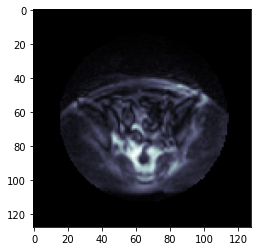

In [37]:
fig = plt.figure()
camera = Camera(fig)  

for i in range(mri.shape[2]):  
    plt.imshow(mri[:,:,i], cmap="bone")
    mask_ = np.ma.masked_where(mask[:,:,i]==0, mask[:,:,i])
    plt.imshow(mask_, alpha=0.5, cmap="autumn")
    # plt.axis("off")
    camera.snap()  # Store the current slice
animation = camera.animate()  # Create the animation

HTML(animation.to_html5_video()) 